In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_load import *
from model_fit_functions import *

from sklearn.utils import shuffle

import pandas as pd
import numpy as np

import pickle

import random
from sklearn.metrics.pairwise import euclidean_distances

import numpy as np
from sklearn.decomposition import PCA

In [2]:
# Load data
data_dict =  load_split_pool(1346, 430, 10, scale = True)

# Pooled X data
train_df_pooled = data_dict["x_pooled"]["train"]
val_df_pooled = data_dict["x_pooled"]["val"]

Directory: Complete_Spectral_Data\Training_Data Physical properties shape: (1346, 5) Spectral prop shape: (1346, 110001)
Directory: Complete_Spectral_Data\Test_Data Physical properties shape: (810, 5) Spectral prop shape: (810, 110001)
Spectral data shape (2156, 110001)
Physical data shape (2156, 5)


In [3]:
data_dict.keys()

dict_keys(['x', 'x_pooled', 'y', 'parameters', 'wavelengths'])

## Load estimated models from pickled objects

In [4]:
# Autoencoder

# file = open('outputs/spca_results_5.txt','rb')
file = open('outputs/simple_autoencoder_loss','rb')
autoenc_simple = pickle.load(file)
file.close()

# Sparse PCA (the number in the filename is lambda regularisation parameter )

# lambda = 7
file = open('outputs/spca_results7_new.txt','rb')
spca_alpha7 = pickle.load(file)
file.close()

# lambda = 5
file = open('outputs/spca_results5_new.txt','rb')
spca_alpha5 = pickle.load(file)
file.close()

# lambda = 4.5
file = open('outputs/spca_results45_new.txt','rb')
spca_alpha45 = pickle.load(file)
file.close()

# lambda = 3.5
file = open('outputs/spca_results35_new.txt','rb')
spca_alpha35 = pickle.load(file)
file.close()

# lambda = 2.5
file = open('outputs/spca_results_025_new.txt','rb')
spca_alpha35 = pickle.load(file)
file.close()

# lambda = 1
file = open('outputs/spca_results_01.txt','rb')
spca_alpha1 = pickle.load(file)
file.close()

# lambda = 0 (same as PCA)
file = open('outputs/spca_results00_new.txt','rb')
spca_alpha00 = pickle.load(file)
file.close()

# lambda = 2.5 plus change ridge penalty - this has no effect on the estimates so not used here
file = open("outputs/spca_results_25_100_ridge_new_small.txt",'rb')
spca_alpha25 = pickle.load(file)
file.close()

# Random projections (two different objects, one fitted to a finer grid of n_components,
# another one for a coarser but longer grid to check convergence properties)

file = open('outputs/randomproj_sequence_long','rb')
spca_randp_long = pickle.load(file)
file.close()

file = open('outputs/randomproj_sequence','rb')
spca_randp = pickle.load(file)
file.close()

file = open('outputs/pca_tau_loss','rb')
pca_tau_loss = pickle.load(file)
file.close()

file = open('outputs/pca','rb')
pca = pickle.load(file)
file.close()

file = open('outputs/pca_trim','rb')
pca_trim = pickle.load(file)
file.close()

file = open('outputs/simple_autoenc_object','rb')
autoencoder = pickle.load(file)
file.close()
# "simple_autoenc_object"

file = open('outputs/simple_autoencoder_loss_finegrid','rb')
autoenc_simple_fineg = pickle.load(file)
file.close()

file = open('outputs/6layer_autoencoder_loss_finegrid','rb')
autoenc_6layer_fineg = pickle.load(file)
file.close()


import tensorflow as tf
file = open('outputs/simple_autoenc_object','rb')
simple_autoenc_object = pickle.load(file)
file.close()

C:\Users\jbryb\gsof_env\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator SparsePCA from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


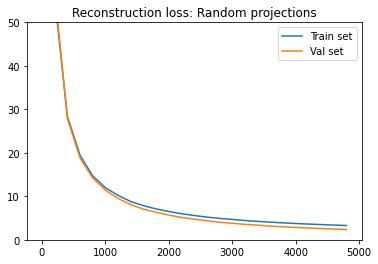

In [5]:
# Plot loss for the random porjections methods

train_dict_long = spca_randp_long["train"]
val_dict_long = spca_randp_long["val"]

n_comp_list = list(val_dict_long.keys())
losses_train_list = [train_dict_long[i]["loss_train"] for i in val_dict_long.keys()]
losses_val_list = [val_dict_long[i]["loss_val"] for i in val_dict_long.keys()]

losses_val_list_adj = list( np.array(losses_val_list)*np.sqrt( np.array(n_comp_list)/val_df_pooled.shape[1] ) )
losses_trainl_list_adj = list( np.array(losses_train_list)*np.sqrt( np.array(n_comp_list)/train_df_pooled.shape[1] ) )


fig, ax = plt.subplots()
ax.plot( np.array(n_comp_list), np.array(losses_train_list) , label = "Train set")
ax.plot( np.array(n_comp_list), np.array(losses_val_list), label = "Val set" )
# ax.set_xlim([50, 250])
ax.set_ylim([0, 50])
ax.set_title("Reconstruction loss: Random projections")
ax.legend()

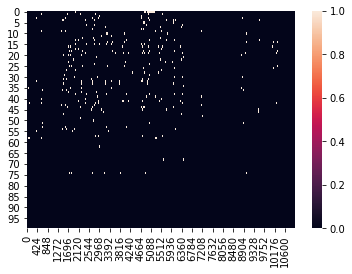

In [6]:
# Plot sparsity of the most regularised matrix estimate
ax = sns.heatmap(pd.DataFrame(np.abs(spca_alpha7[7]["spca_object"].components_[:250, :]) > 0))
plt.show()

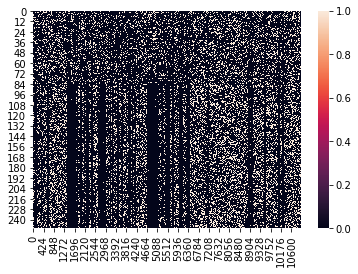

In [7]:
# Plot sparsity of the least regularise dmatrix estimate
ax = sns.heatmap(pd.DataFrame(np.abs(spca_alpha1[1]["spca_object"].components_[:250, :]) > 0))
plt.show()

In [8]:

# We need to calculate reconstr loss for sparse PCA as this is not contained in the loaded objects

def rescale_back(observation, mean, std):
    '''
    Reverse standardisation using the given parameters
    '''
    return( observation*std + mean ) 


def calculate_reconstr_loss_spca(spca_dict, x_original, n_comp):
    '''Given a dictionary of spca object (recovered from the pickle file), original data and number of 
    principal components to use, calculate MSE reconstruction loss.'''
    x_projected = x_original @ spca_dict["spca_object"].components_[:n_comp, :].T
    # Transform projected data back to the original space
    x_original_space = x_projected @ spca_dict["spca_object"].components_[:n_comp, :] # project back
    
    mean = data_dict["parameters"]["mean"]
    std =  data_dict["parameters"]["std"]
    x_original = rescale_back(x_original, mean, std)
    x_original_space = rescale_back( x_original_space, mean, std )
    
    loss = ((x_original - x_original_space) ** 2).sum().sum()/x_original.size
    
    return(loss)

In [9]:
# Number of elements to use / size of dimension to which to reduce

n_comp_list_pca = list( np.arange(1, 100, 2) )

In [10]:
# For different values of regularisation parameter and different number
# of components, calculate reconstructoion loss of pca.

# These losses are stored in separate lists, and later plotted.

random.seed(8765)

spca_loss_aplha5 = []
spca_loss_aplha1 = []
spca_loss_aplha25 = []
spca_loss_aplha35 = []
spca_loss_aplha45 = []
spca_loss_aplha7 = []
spca_loss_aplha0 = []

# to do: def calculate_loss_and_distances_spca(spca_dict)

for n_comp in n_comp_list_pca:
    
    loss5  = calculate_reconstr_loss_spca(spca_alpha5[5], val_df_pooled, n_comp)
    loss1  = calculate_reconstr_loss_spca(spca_alpha1[1], val_df_pooled, n_comp)
    loss25 = calculate_reconstr_loss_spca(spca_alpha25[2.5], val_df_pooled, n_comp)
    
    loss7  = calculate_reconstr_loss_spca(spca_alpha7[7], val_df_pooled, n_comp)
    loss45  = calculate_reconstr_loss_spca(spca_alpha45[4.5], val_df_pooled, n_comp)
    
    loss0 = calculate_reconstr_loss_spca(spca_alpha00[0], val_df_pooled, n_comp)
  
    
    spca_loss_aplha5.append(loss5)
    spca_loss_aplha1.append(loss1)
    spca_loss_aplha25.append(loss25)
    spca_loss_aplha45.append(loss45)
    spca_loss_aplha7.append(loss7)
    spca_loss_aplha0.append(loss0)

### PCA

In [11]:
pca_loss = [ pca["restricted_spaces"][i]["loss"] for i in pca["restricted_spaces"] ]
pca_trim_loss = [ pca_trim["restricted_spaces"][i]["loss"] for i in pca_trim["restricted_spaces"] ]

Text(0.5, 0, 'Number of components')

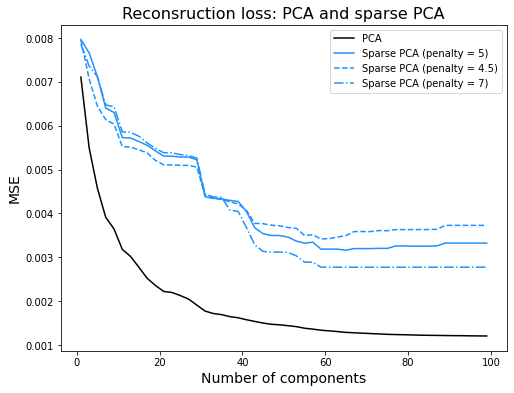

In [12]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot( np.array(n_comp_list_pca), np.array(pca_loss) , label = "PCA", color = "black")
ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha5), label = "Sparse PCA (penalty = 5)" , color = "dodgerblue")
ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha45), label = "Sparse PCA (penalty = 4.5)", color = "dodgerblue",
       linestyle = "--")
ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha7), label = "Sparse PCA (penalty = 7)", color = "dodgerblue", 
        linestyle = "-." )
# ax.plot( np.array(autoenc_simple_fineg["dim"]), np.array(autoenc_simple_fineg["loss"]), label = "Autoencoder (2 layer)", color = "orange" )
ax.legend()
ax.set_title("Reconsruction loss: PCA and sparse PCA", fontsize = 16)
ax.set_ylabel("MSE", fontsize = 14)
ax.set_xlabel("Number of components", fontsize = 14)

### Different loss?

In [13]:
def calculate_reconstr_loss_spca(spca_dict, x_original, n_comp):
    '''Given a dictionary of spca object (recovered from the pickle file), original data and number of 
    principal components to use, calculate MSE reconstruction loss.'''
    
#     rescale_back(obs_projected_spca, data_dict["parameters"]["mean"], data_dict["parameters"]["std"])
    
    x_projected = x_original @ spca_dict["spca_object"].components_[:n_comp, :].T
    # Transform projected data back to the original space
    x_original_space = x_projected @ spca_dict["spca_object"].components_[:n_comp, :] # project back
    
    x_original = rescale_back(x_original, data_dict["parameters"]["mean"], data_dict["parameters"]["std"])
    x_original_space = rescale_back( x_original_space, data_dict["parameters"]["mean"], data_dict["parameters"]["std"] )
    
    
    
    loss = ((x_original - x_original_space) ** 2).sum().sum()/x_original.size
    
    return(loss)

In [14]:
# pca_loss = [ pca["restricted_spaces"][i]["loss"] for i in pca["restricted_spaces"] ]
# pca_trim_loss = [ pca_trim["restricted_spaces"][i]["loss"] for i in pca_trim["restricted_spaces"] ]

In [20]:
# Rescale vlaidation set back:
val_df_pooled_rescaled = rescale_back(val_df_pooled, data_dict["parameters"]["mean"], data_dict["parameters"]["std"]) 


In [16]:
spca_loss_aplha5 = []
spca_loss_aplha1 = []
spca_loss_aplha25 = []
spca_loss_aplha35 = []
spca_loss_aplha45 = []
spca_loss_aplha7 = []
spca_loss_aplha0 = []
n_comp_list_pca = list( np.arange(1, 100, 2) )


dist_mean_pca = []
dist_std_pca = []

for n_comp in n_comp_list_pca:
    
    loss5  = calculate_reconstr_loss_spca(spca_alpha5[5], val_df_pooled, n_comp)
    loss1  = calculate_reconstr_loss_spca(spca_alpha1[1], val_df_pooled, n_comp)
    loss25 = calculate_reconstr_loss_spca(spca_alpha25[2.5], val_df_pooled, n_comp)
    
    loss7  = calculate_reconstr_loss_spca(spca_alpha7[7], val_df_pooled, n_comp)
    loss45  = calculate_reconstr_loss_spca(spca_alpha45[4.5], val_df_pooled, n_comp)
    
    loss0 = calculate_reconstr_loss_spca(spca_alpha00[0], val_df_pooled, n_comp)
    
    spca_loss_aplha5.append(loss5)
    spca_loss_aplha1.append(loss1)
    spca_loss_aplha25.append(loss25)
    spca_loss_aplha45.append(loss45)
    spca_loss_aplha7.append(loss7)
    spca_loss_aplha0.append(loss0)

Text(0.5, 0, 'Number of components')

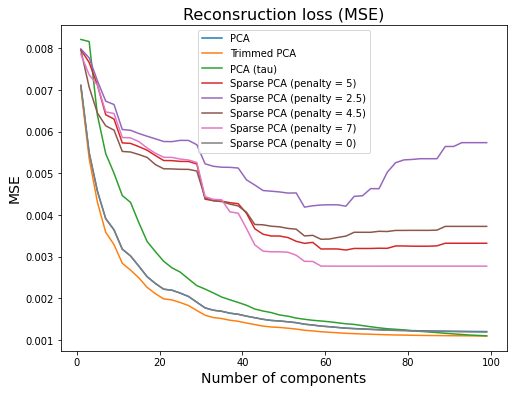

In [17]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot( np.array(n_comp_list_pca), np.array(pca_loss) , label = "PCA")
ax.plot( np.array(n_comp_list_pca), np.array(pca_trim_loss) , label = "Trimmed PCA")
ax.plot( np.array(pca_tau_loss["ncomps"]), np.array(pca_tau_loss["loss"]) , label = "PCA (tau)")
ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha5), label = "Sparse PCA (penalty = 5)" )
ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha25), label = "Sparse PCA (penalty = 2.5)" )
# ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha35), label = "Sparse PCA (penalty = 3.5)" )
ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha45), label = "Sparse PCA (penalty = 4.5)" )
ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha7), label = "Sparse PCA (penalty = 7)" )
ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha0), label = "Sparse PCA (penalty = 0)" )
# ax.plot( np.array(autoenc_simple["dim"]), np.array(autoenc_simple["loss"]), label = "Autoencoder (2 layer)" )
# ax.plot( np.array(autoenc_pca["dim"]), np.array(autoenc_pca["loss"]), label = "Autoencoder (1 linear layer)" )
ax.legend()
ax.set_title("Reconsruction loss (MSE)", fontsize = 16)
ax.set_ylabel("MSE", fontsize = 14)
ax.set_xlabel("Number of components", fontsize = 14)

Text(0.5, 0, 'Number of components')

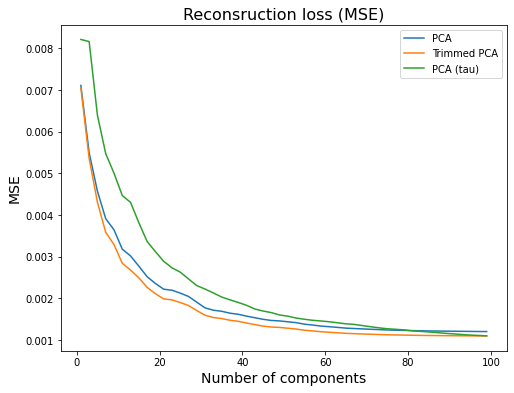

In [18]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot( np.array(n_comp_list_pca), np.array(pca_loss) , label = "PCA")
ax.plot( np.array(n_comp_list_pca), np.array(pca_trim_loss) , label = "Trimmed PCA")
ax.plot( np.array(pca_tau_loss["ncomps"]), np.array(pca_tau_loss["loss"]) , label = "PCA (tau)")
# ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha5), label = "Sparse PCA (penalty = 5)" )
# ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha25), label = "Sparse PCA (penalty = 2.5)" )
# # ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha35), label = "Sparse PCA (penalty = 3.5)" )
# ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha45), label = "Sparse PCA (penalty = 4.5)" )
# ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha7), label = "Sparse PCA (penalty = 7)" )
# ax.plot( np.array(n_comp_list_pca), np.array(spca_loss_aplha0), label = "Sparse PCA (penalty = 0)" )
# ax.plot( np.array(autoenc_simple["dim"]), np.array(autoenc_simple["loss"]), label = "Autoencoder (2 layer)" )
# ax.plot( np.array(autoenc_pca["dim"]), np.array(autoenc_pca["loss"]), label = "Autoencoder (1 linear layer)" )
ax.legend()
ax.set_title("Reconsruction loss (MSE)", fontsize = 16)
ax.set_ylabel("MSE", fontsize = 14)
ax.set_xlabel("Number of components", fontsize = 14)

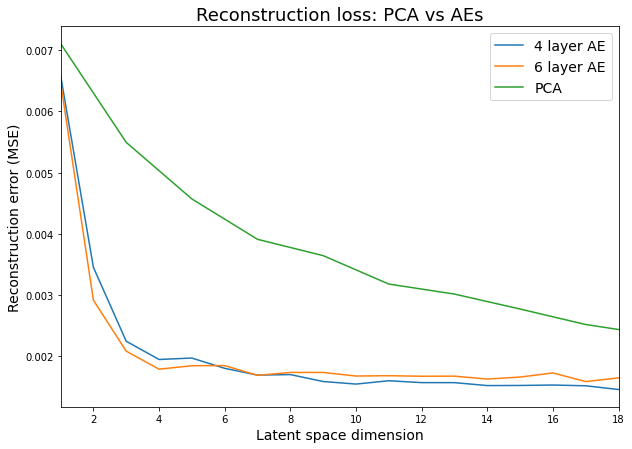

In [19]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(autoenc_simple_fineg["dim"], autoenc_simple_fineg["loss"], label = "4 layer AE")
ax.plot(autoenc_6layer_fineg ["dim"], autoenc_6layer_fineg ["loss"], label = "6 layer AE" )
ax.plot( np.array(np.arange(1, 20, 2)), pca_loss[:len(np.array(np.arange(1, 20, 2)))] , label = "PCA")
ax.set_xlabel("Latent space dimension", fontsize = 14)
ax.set_ylabel("Reconstruction error (MSE)", fontsize = 14)
ax.set(xlim = (1,18) )
ax.set_title("Reconstruction loss: PCA vs AEs", fontsize = 18)
ax.legend(fontsize = 14);